In [1]:
import os, sys, subprocess
conda_prefix = os.environ.get("CONDA_PREFIX", sys.prefix)  # raíz del env actual
os.environ["JAVA_HOME"] = conda_prefix
os.environ["PATH"] = f"{conda_prefix}/bin:" + os.environ["PATH"]

# Verifica que Java responde
print("JAVA_HOME:", os.environ["JAVA_HOME"])
print(subprocess.run(["java", "-version"], capture_output=True, text=True).stderr)

JAVA_HOME: /opt/conda
openjdk version "11.0.27-internal" 2025-04-15
OpenJDK Runtime Environment (build 11.0.27-internal+0-adhoc..src)
OpenJDK 64-Bit Server VM (build 11.0.27-internal+0-adhoc..src, mixed mode)



In [2]:
import os
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

In [3]:
base_dir = os.path.expanduser("~")  # carpeta local del cuaderno

In [4]:
builder = (
    SparkSession.builder
    .appName("spark-local-delta")
    .config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-77594802-1248-4884-816f-039e916271f5;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.2.0 in central
	found io.delta#delta-storage;3.2.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 405ms :: artifacts dl 13ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.2.0 from central in [default]
	io.delta#delta-storage;3.2.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default  

In [5]:
# Lee el CSV local que hayas subido al Jupyter (sin S3)
csv_path   = f"file://{base_dir}/STAR.csv"
delta_path = f"file://{base_dir}/delta/STAR"
parquet_path = f"file://{base_dir}/parquet/STAR"

In [6]:
df = (spark.read.format("csv").option("header", True).option("inferSchema", True).load(csv_path))

In [7]:
(df.write.format("delta").mode("overwrite").save(delta_path))

25/11/11 18:31:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

In [8]:
spark.read.format("delta").load(delta_path).show(5)

+----+------+---------+-------+------------+-----+------------+------------+-----+-----+-----+-----+-----+-----+-----+-----+--------+------+--------+--------+----------+--------+--------+--------+--------+--------+--------+--------+---------+---------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------+-------+-------+-------+---------+---------+---------+---------+
|  c0|gender|ethnicity|  birth|       stark|star1|       star2|       star3|readk|read1|read2|read3|mathk|math1|math2|math3|  lunchk|lunch1|  lunch2|  lunch3|   schoolk| school1| school2| school3| degreek| degree1| degree2| degree3|  ladderk|  ladder1|   ladder2|   ladder3|experiencek|experience1|experience2|experience3|tethnicityk|tethnicity1|tethnicity2|tethnicity3|systemk|system1|system2|system3|schoolidk|schoolid1|schoolid2|schoolid3|
+----+------+---------+-------+------------+-----+------------+------------+-----+-----+-----+-----+-----+-----+--

In [9]:
from pyspark.sql.types import DoubleType
df = df.withColumn("readk",df["readk"].cast(DoubleType()))
df = df.withColumn("read1",df["read1"].cast(DoubleType()))
df = df.withColumn("read2",df["read2"].cast(DoubleType()))
df = df.withColumn("read3",df["read3"].cast(DoubleType()))
df = df.withColumn("mathk",df["mathk"].cast(DoubleType()))
df = df.withColumn("math1",df["math1"].cast(DoubleType()))
df = df.withColumn("math2",df["math2"].cast(DoubleType()))
df = df.withColumn("math3",df["math3"].cast(DoubleType()))
df = df.withColumn("experiencek",df["experiencek"].cast(DoubleType()))
df = df.withColumn("experience1",df["experience1"].cast(DoubleType()))
df = df.withColumn("experience2",df["experience2"].cast(DoubleType()))
df = df.withColumn("experience3",df["experience3"].cast(DoubleType()))

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer,OneHotEncoder

colGen = ['gender','ethnicity','birth']
colGenI = ['genderI','ethnicityI','birthI']
colGenE = ['genderE','ethnicityE','birthE']

colk = ['stark','lunchk','schoolk','degreek','ladderk','tethnicityk','systemk','schoolidk']
colkI = ['starkI','lunchkI','schoolkI','degreekI', 'ladderkI','tethnicitykI','systemkI','schoolidkI']
colkE =['starkE','lunchkE','schoolkE','degreekE', 'ladderkE','tethnicitykE','systemkE','schoolidkE']

col1 =['star1','lunch1','school1','degree1', 'ladder1','tethnicity1','system1','schoolid1']
col1I = ['star1I','lunch1I','school1I','degree1I', 'ladder1I','tethnicity1I','system1I','schoolid1I']
col1E =['star1E','lunch1E','school1E','degree1E', 'ladder1E','tethnicity1E','system1E','schoolid1E']

col2 =['star2','lunch2','school2','degree2', 'ladder2','tethnicity2','system2','schoolid2']
col2I = ['star2I','lunch2I','school2I','degree2I', 'ladder2I','tethnicity2I','system2I','schoolid2I']
col2E =['star2E','lunch2E','school2E','degree2E', 'ladder2E','tethnicity2E','system2E','schoolid2E']

col3 =['star3','lunch3','school3','degree3', 'ladder3','tethnicity3','system3','schoolid3']
col3I = ['star3I','lunch3I','school3I','degree3I', 'ladder3I','tethnicity3I','system3I','schoolid3I']
col3E =['star3E','lunch3E','school3E','degree3E', 'ladder3E','tethnicity3E','system3E','schoolid3E']

input_cols = colGen + colk + col1 + col2 + col3
index_cols = colGenI + colkI + col1I + col2I + col3I
encoded_cols = colGenE + colkE + col1E + col2E + col3E

indexer = StringIndexer(inputCols=input_cols, outputCols=index_cols)
encoder = OneHotEncoder(inputCols=index_cols, outputCols=encoded_cols)
pipeline = Pipeline(stages=[indexer, encoder])
df = pipeline.fit(df).transform(df)

In [ ]:
df_pandas = df.toPandas()

<Axes: title={'center': 'read3'}, xlabel='star3'>

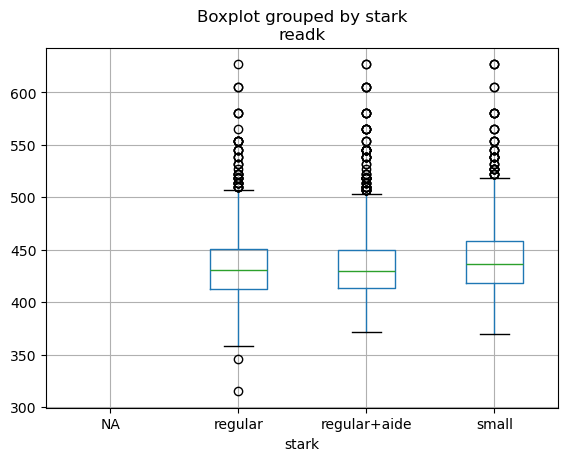

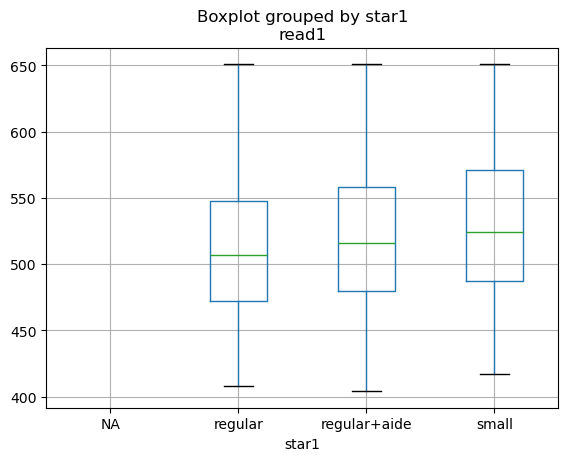

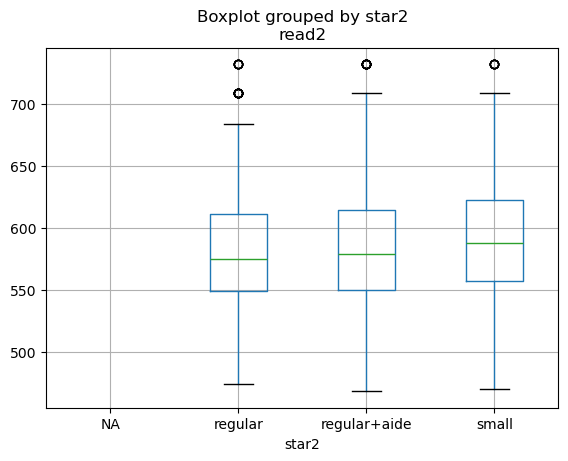

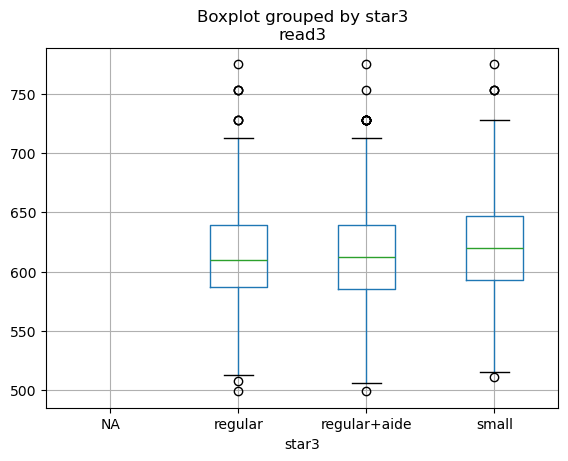

In [20]:
df_pandas.boxplot(by='stark', column=['readk'])
df_pandas.boxplot(by='star1', column=['read1'])
df_pandas.boxplot(by='star2', column=['read2'])
df_pandas.boxplot(by='star3', column=['read3'])

<Axes: title={'center': 'math3'}, xlabel='star3'>

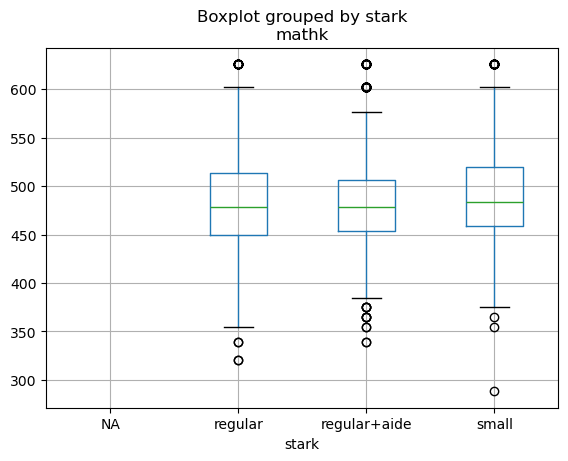

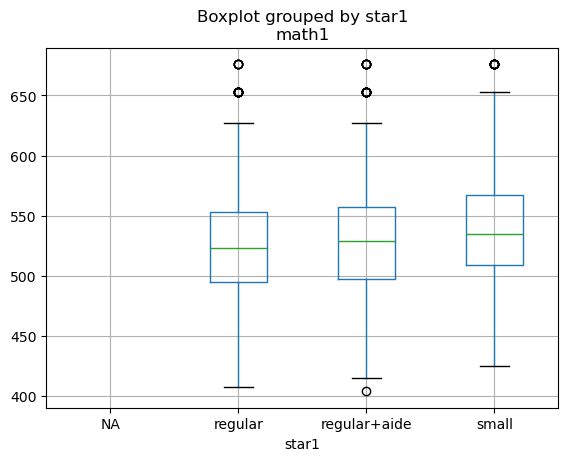

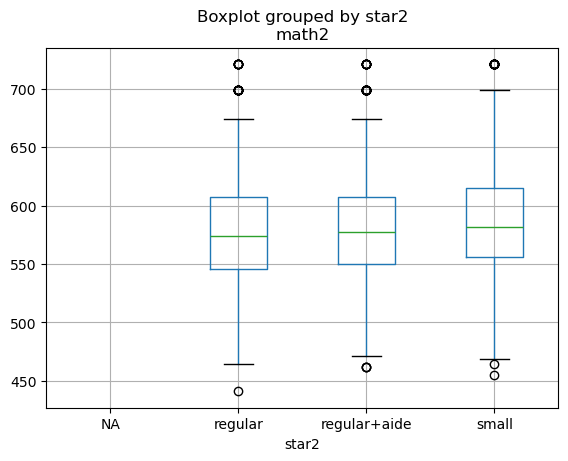

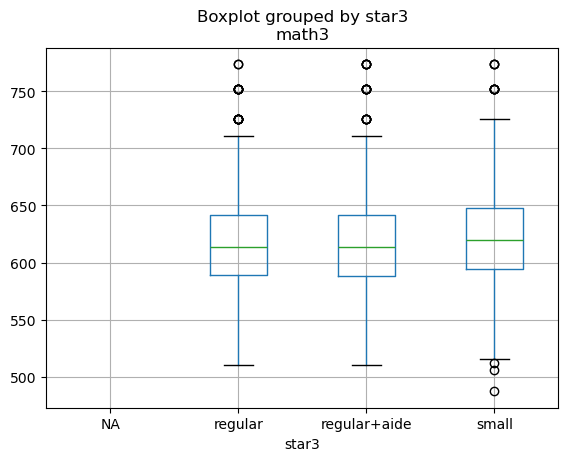

In [21]:
df_pandas.boxplot(by='stark', column=['mathk'])
df_pandas.boxplot(by='star1', column=['math1'])
df_pandas.boxplot(by='star2', column=['math2'])
df_pandas.boxplot(by='star3', column=['math3'])

In [ ]:
colinputk = ['genderI','ethnicityI','birthI','starkI','lunchkI','schoolkI','degreekI','ladderkI','tethnicitykI']
coloutputk =['readI'] 